# Exercícios

1. Inclua um modelo de regressão linear sem regularização. Para isso use um *flat prior*. Inclua este modelo na comparação. Esse modelo possui uma capacidade preditiva melhor que os outros?
2. Refaça os modelos de regressão de Ridge, Lasso e Robusto para o item graõs de soja ao invés de batatas.
3. O modelo robusto acima diferiu dos outros significativamente? Plote as retas comparando os modelos.
4. Identifique o melhor modelo usando o ELPD LOO.
5. Faça os modelos de regressão e analise o melhor usando as relações *crop yield vs pesticide* e *crop yield vs rain fall*. Você terá que usar a função groupby do pandas.

In [1]:
!wget https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv

--2025-03-09 22:04:05--  https://raw.githubusercontent.com/romefeller/predictive/main/dados/yield_df.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1565376 (1.5M) [text/plain]
Saving to: ‘yield_df.csv’

yield_df.csv        100%[===================>]   1.49M  --.-KB/s    in 0.1s    

2025-03-09 22:04:06 (15.1 MB/s) - ‘yield_df.csv’ saved [1565376/1565376]



In [2]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [3]:
crop = pd.read_csv("yield_df.csv")

In [4]:
item = "Potatoes"

product = crop[(crop["Item"] == item)]

product_crop = product[["avg_temp","hg/ha_yield"]]

In [5]:
obs = product["hg/ha_yield"]

In [6]:
obs_norm = (obs - obs.mean())/obs.std()

obs_norm

,hg/ha_yield
1,-1.425696
7,-1.306283
13,-1.251647
19,-1.085384
24,-1.267882
...,...
28204,-0.360514
28212,-0.353135
28220,-0.347663
28228,-0.299057


**1. Inclua um modelo de regressão linear sem regularização. Para isso use um *flat prior*. Inclua este modelo na comparação. Esse modelo possui uma capacidade preditiva melhor que os outros?**

In [7]:
t = product["avg_temp"]
obs = product["hg/ha_yield"]
with pm.Model() as flat_model:
  a = pm.Flat("a")
  b = pm.Flat("b")

  eps = pm.Flat("eps")

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [8]:
with flat_model:
  trace_flat = pm.sample()

Output()

In [9]:
pm.summary(trace_flat)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.003,0.044,0.925,1.091,0.001,0.001,921.0,922.0,1.0
b,-0.053,0.002,-0.057,-0.049,0.000,0.000,939.0,794.0,1.0
eps,0.928,0.010,0.909,0.947,0.000,0.000,1130.0,1009.0,1.0


In [10]:
with pm.Model() as crop_model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [11]:
with crop_model_norm:
  trace_norm = pm.sample()

Output()

In [12]:
pm.summary(trace_norm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.002,0.039,0.927,1.070,0.001,0.001,875.0,965.0,1.0
b,-0.053,0.002,-0.056,-0.049,0.000,0.000,937.0,1052.0,1.0
eps,0.928,0.010,0.907,0.945,0.000,0.000,1190.0,1117.0,1.0


In [13]:
with pm.Model() as crop_lasso:
  a = pm.Laplace("a",0,1)
  b = pm.Laplace("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [14]:
with crop_lasso:
  trace_lasso = pm.sample()

Output()

In [15]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.003,0.039,0.933,1.081,0.001,0.001,862.0,923.0,1.0
b,-0.053,0.002,-0.056,-0.049,0.000,0.000,874.0,852.0,1.0
eps,0.928,0.010,0.910,0.946,0.000,0.000,1138.0,975.0,1.0


In [16]:
with pm.Model() as crop_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)
  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t,sigma=eps,observed=obs_norm)

In [17]:
with crop_robust:
  trace_robust = pm.sample()

Output()

In [18]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.964,0.044,0.884,1.046,0.001,0.001,922.0,998.0,1.0
b,-0.051,0.002,-0.055,-0.047,0.000,0.000,964.0,1200.0,1.0
df,21.224,3.324,15.173,27.272,0.098,0.069,1131.0,976.0,1.0
eps,0.892,0.012,0.871,0.914,0.000,0.000,919.0,923.0,1.0


<ipython-input-19-7d195928f9f1>:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


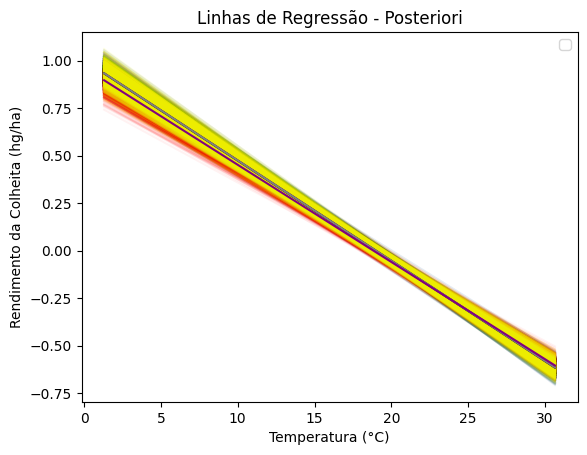

In [19]:
a_samples = trace_lasso.posterior["a"].values.flatten()
b_samples = trace_lasso.posterior["b"].values.flatten()

a_samples_r = trace_norm.posterior["a"].values.flatten()
b_samples_r = trace_norm.posterior["b"].values.flatten()

a_samples_f = trace_flat.posterior["a"].values.flatten()
b_samples_f = trace_flat.posterior["b"].values.flatten()

a_samples_ro = trace_robust.posterior["a"].values.flatten()
b_samples_ro = trace_robust.posterior["b"].values.flatten()

t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

for a_sample_r, b_sample_r in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample_r + b_sample_r * t_values, color="green", alpha=0.05)

for a_sample_ro, b_sample_ro in zip(a_samples_ro, b_samples_ro):
    plt.plot(t_values, a_sample_ro + b_sample_ro * t_values, color="red", alpha=0.05)

for a_sample_f, b_sample_f in zip(a_samples_f, b_samples_f):
    plt.plot(t_values, a_sample_f + b_sample_f * t_values, color="yellow", alpha=0.05)

mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange" )

mean_a_r = a_samples_r.mean()
mean_b_r = b_samples_r.mean()
plt.plot(t_values, mean_a_r + mean_b_r * t_values, color="black" )

mean_a_f= a_samples_f.mean()
mean_b_f = b_samples_f.mean()
plt.plot(t_values, mean_a_f + mean_b_f * t_values, color="grey" )

mean_a_ro= a_samples_ro.mean()
mean_b_ro = b_samples_ro.mean()
plt.plot(t_values, mean_a_ro + mean_b_ro * t_values, color="purple" )

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

In [20]:
with flat_model:
  pm.compute_log_likelihood(trace_flat)

with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

with crop_robust:
    pm.compute_log_likelihood(trace_robust)


Output()

Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

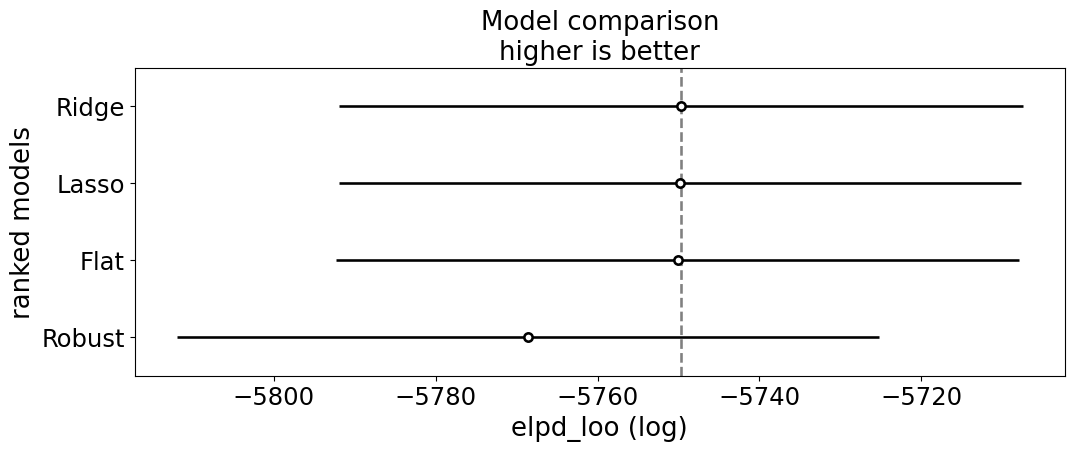

In [21]:
model_compare = az.compare(
    {
        "Flat": trace_flat,
        "Ridge": trace_norm,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [22]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Ridge,0,-5749.698815,2.975427,0.000000,3.914887e-01,42.219581,0.000000,False,log
Lasso,1,-5749.814411,3.057522,0.115595,3.488372e-01,42.180432,0.060765,False,log
Flat,2,-5750.109509,3.419191,0.410694,2.596740e-01,42.212336,0.036364,False,log
Robust,3,-5768.607814,3.499115,18.908999,3.363249e-08,43.351457,2.402201,False,log


# **Análise**

**Médias dos Parâmetros:**
- Modelo sem regularização (prior flat): 1.003
- Modelo Ridge: 1.002
- Modelo Lasso: 1.003
- Modelo Robusto: 0.964

**Convergência dos Modelos:**
O r_hat igual a 1.0 em todos os modelos indica que houve convergência satisfatória e o gráfico e as estatísticas de comparação mostram que a utilização de um prior flat na estimação só teve uma leve diferença em relação aos modelos de regularização lasso e de regularização de Ridge, por último ficou a regressão robusta.

2. Refaça os modelos de regressão de Ridge, Lasso e Robusto para o item graõs de soja ao invés de batatas.

In [23]:
item_soja = "Soybeans"

product = crop[(crop["Item"] == item_soja )]

product_crop = product[["avg_temp","hg/ha_yield"]]

In [24]:
with pm.Model() as crop_model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [25]:
with crop_model_norm:
  trace_norm = pm.sample()

Output()

In [26]:
pm.summary(trace_norm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.004,0.040,0.927,1.076,0.002,0.001,548.0,705.0,1.01
b,-0.053,0.002,-0.056,-0.049,0.000,0.000,594.0,850.0,1.01
eps,0.928,0.010,0.910,0.948,0.000,0.000,1078.0,896.0,1.00


In [27]:
with pm.Model() as crop_lasso:
  a = pm.Laplace("a",0,1)
  b = pm.Laplace("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t,eps,observed=obs_norm)

In [28]:
with crop_lasso:
  trace_lasso = pm.sample()

Output()

In [29]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.999,0.040,0.925,1.069,0.002,0.001,692.0,1009.0,1.0
b,-0.053,0.002,-0.056,-0.049,0.000,0.000,701.0,866.0,1.0
eps,0.928,0.010,0.909,0.947,0.000,0.000,1313.0,1106.0,1.0


In [30]:
with pm.Model() as crop_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)
  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t,sigma=eps,observed=obs_norm)

In [31]:
with crop_robust:
  trace_robust = pm.sample()

Output()

In [32]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.962,0.044,0.881,1.047,0.001,0.001,899.0,773.0,1.0
b,-0.051,0.002,-0.055,-0.047,0.000,0.000,909.0,874.0,1.0
df,21.477,3.134,15.770,27.361,0.091,0.066,1229.0,944.0,1.0
eps,0.893,0.011,0.872,0.913,0.000,0.000,1306.0,1163.0,1.0


**3.O modelo robusto acima diferiu dos outros significativamente? Plote as retas comparando os modelos.**

<ipython-input-33-ed2c3d3ff899>:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


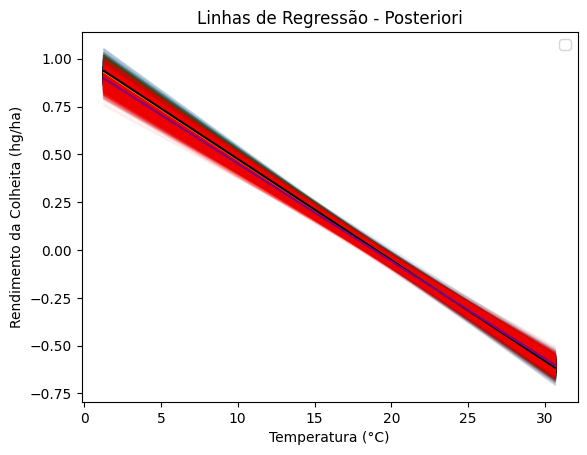

In [33]:
a_samples = trace_lasso.posterior["a"].values.flatten()
b_samples = trace_lasso.posterior["b"].values.flatten()

a_samples_r = trace_norm.posterior["a"].values.flatten()
b_samples_r = trace_norm.posterior["b"].values.flatten()

a_samples_ro = trace_robust.posterior["a"].values.flatten()
b_samples_ro = trace_robust.posterior["b"].values.flatten()

t_values = np.linspace(t.min(), t.max(), 100)

for a_sample, b_sample in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample + b_sample * t_values, color="blue", alpha=0.05)

for a_sample_r, b_sample_r in zip(a_samples, b_samples):
    plt.plot(t_values, a_sample_r + b_sample_r * t_values, color="green", alpha=0.05)

for a_sample_ro, b_sample_ro in zip(a_samples_ro, b_samples_ro):
    plt.plot(t_values, a_sample_ro + b_sample_ro * t_values, color="red", alpha=0.05)


mean_a = a_samples.mean()
mean_b = b_samples.mean()
plt.plot(t_values, mean_a + mean_b * t_values, color="orange" )

mean_a_r = a_samples_r.mean()
mean_b_r = b_samples_r.mean()
plt.plot(t_values, mean_a_r + mean_b_r * t_values, color="black" )


mean_a_ro= a_samples_ro.mean()
mean_b_ro = b_samples_ro.mean()
plt.plot(t_values, mean_a_ro + mean_b_ro * t_values, color="purple" )

plt.xlabel("Temperatura (°C)")
plt.ylabel("Rendimento da Colheita (hg/ha)")
plt.title("Linhas de Regressão - Posteriori")
plt.legend()
plt.show()

**Análise** visualmente falando o modelo robusto está bem semelhante aos outros por mais que sua aréa seja maior (em vermelho) mas não diferenças notaveis.

**3.Identifique o melhor modelo usando o ELPD LOO.**

In [34]:

with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

with crop_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

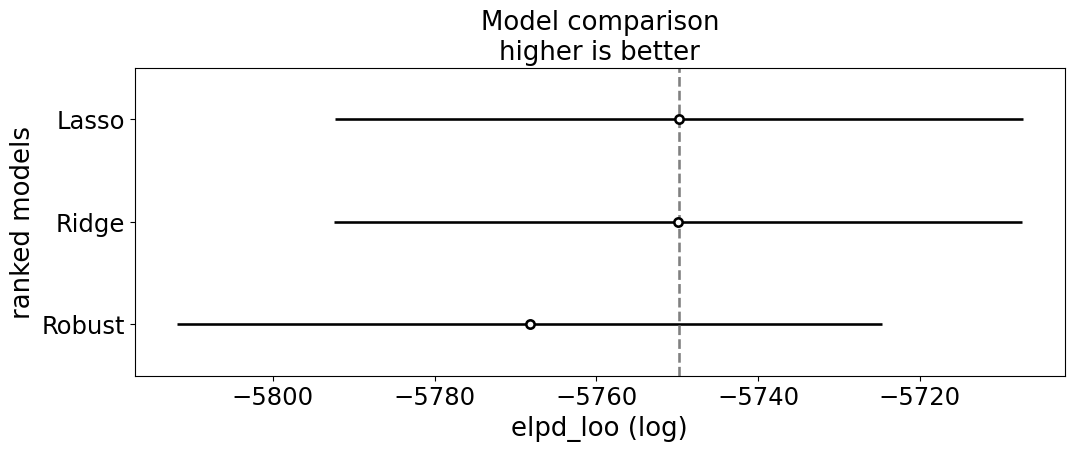

In [35]:
model_compare = az.compare(
    {
        "Ridge": trace_norm,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [36]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Lasso,0,-5749.825320,3.058370,0.000000,5.151713e-01,42.538509,0.000000,False,log
Ridge,1,-5749.889182,3.159619,0.063862,4.848286e-01,42.519783,0.135637,False,log
Robust,2,-5768.236808,3.437910,18.411488,1.111142e-07,43.624650,2.372062,False,log


O melhor modelo foi o de Lasso seguido bem de perto por Ridge (diferença de ~0.10 no elpd) e em terceiro lugar o Robusto

5. Faça os modelos de regressão e analise o melhor usando as relações *crop yield vs pesticide* e *crop yield vs rain fall*. Você terá que usar a função groupby do pandas.


In [37]:
item = "Potatoes"

product = crop[(crop["Item"] == item)]

product_crop_p = product[["pesticides_tonnes","hg/ha_yield"]]
t_p = product["pesticides_tonnes"]

with pm.Model() as crop_model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t_p,eps,observed=obs_norm)


In [38]:
with crop_model_norm:
  trace_norm = pm.sample()

Output()

In [39]:
pm.summary(trace_norm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.124,0.018,-0.159,-0.090,0.001,0.0,957.0,858.0,1.0
b,0.000,0.000,0.000,0.000,0.000,0.0,1549.0,1472.0,1.0
eps,0.979,0.011,0.958,0.997,0.000,0.0,853.0,804.0,1.0


In [40]:
with pm.Model() as crop_lasso:
  a = pm.Laplace("a",0,1)
  b = pm.Laplace("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t_p,eps,observed=obs_norm)

In [41]:
with crop_lasso:
  trace_lasso = pm.sample()

Output()

In [42]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.124,0.017,-0.155,-0.091,0.001,0.0,1063.0,923.0,1.0
b,0.000,0.000,0.000,0.000,0.000,0.0,1764.0,1260.0,1.0
eps,0.979,0.010,0.960,0.998,0.000,0.0,929.0,921.0,1.0


In [43]:
with pm.Model() as crop_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)
  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t_p,sigma=eps,observed=obs_norm)

In [44]:
with crop_robust:
  trace_robust = pm.sample()

Output()

In [45]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.220,0.018,-0.256,-0.188,0.001,0.001,617.0,619.0,1.0
b,0.000,0.000,0.000,0.000,0.000,0.000,1379.0,1756.0,1.0
df,6.490,0.769,5.088,7.964,0.027,0.019,799.0,992.0,1.0
eps,0.828,0.018,0.794,0.860,0.001,0.000,817.0,1015.0,1.0


In [46]:
with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

with crop_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

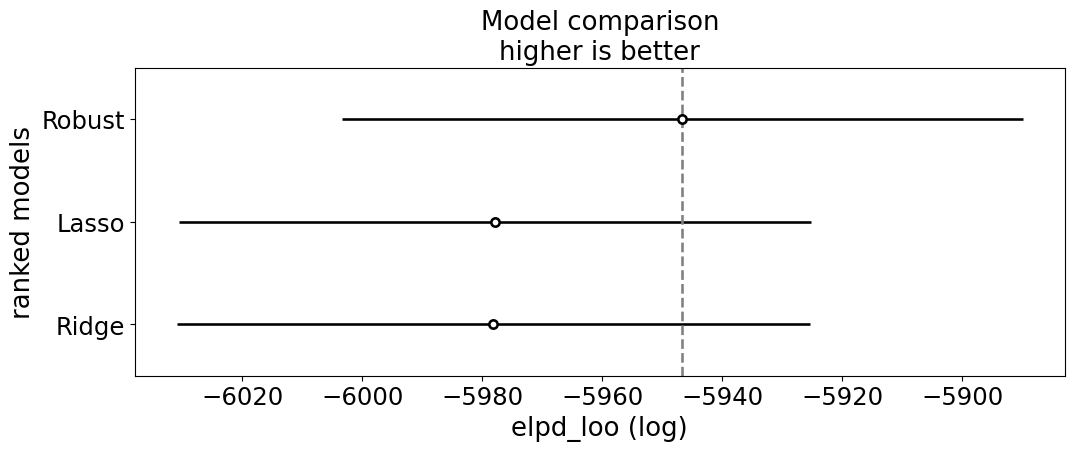

In [47]:
model_compare = az.compare(
    {
        "Ridge": trace_norm,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [48]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Robust,0,-5946.658268,3.588975,0.000000,0.998499,56.685880,0.000000,False,log
Lasso,1,-5977.882946,2.483072,31.224678,0.000889,52.627743,10.725332,False,log
Ridge,2,-5978.133538,2.768523,31.475270,0.000612,52.698960,10.706634,False,log


In [49]:
item = "Potatoes"

product = crop[(crop["Item"] == item)]

product_crop_p = product[["average_rain_fall_mm_per_year","hg/ha_yield"]]
t_r = product["average_rain_fall_mm_per_year"]

with pm.Model() as crop_model_norm:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t_r,eps,observed=obs_norm)

In [50]:
with crop_model_norm:
  trace_norm = pm.sample()

Output()

In [51]:
pm.summary(trace_norm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.191,0.028,0.143,0.245,0.001,0.001,893.0,1207.0,1.0
b,-0.000,0.000,-0.000,-0.000,0.000,0.000,850.0,1114.0,1.0
eps,0.992,0.011,0.971,1.012,0.000,0.000,1129.0,1194.0,1.0


In [52]:
with pm.Model() as crop_lasso:
  a = pm.Laplace("a",0,1)
  b = pm.Laplace("b",0,1)

  eps = pm.Normal("eps",0,1)

  likelihood = pm.Normal("y_obs",a+b*t_r,eps,observed=obs_norm)

In [53]:
with crop_lasso:
  trace_lasso = pm.sample()

Output()

In [54]:
pm.summary(trace_lasso)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.190,0.028,0.142,0.246,0.001,0.001,1148.0,1260.0,1.0
b,-0.000,0.000,-0.000,-0.000,0.000,0.000,1182.0,965.0,1.0
eps,0.992,0.011,0.973,1.013,0.000,0.000,1413.0,1248.0,1.0


In [55]:
with pm.Model() as crop_robust:
  a = pm.Normal("a",0,1)
  b = pm.Normal("b",0,1)

  eps = pm.Normal("eps",0,1)
  df = pm.Exponential("df",1)

  likelihood = pm.StudentT("y_obs",nu=df,mu=a+b*t_r,sigma=eps,observed=obs_norm)

In [56]:
with crop_robust:
  trace_robust = pm.sample()

Output()

In [57]:
pm.summary(trace_robust)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.133,0.029,0.076,0.184,0.001,0.001,886.0,874.0,1.01
b,-0.000,0.000,-0.000,-0.000,0.000,0.000,923.0,892.0,1.00
df,8.395,1.180,6.289,10.613,0.037,0.026,1003.0,1190.0,1.00
eps,0.875,0.017,0.841,0.907,0.001,0.000,1040.0,867.0,1.00


In [58]:
with crop_model_norm:
    pm.compute_log_likelihood(trace_norm)

with crop_lasso:
    pm.compute_log_likelihood(trace_lasso)

with crop_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

Output()

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

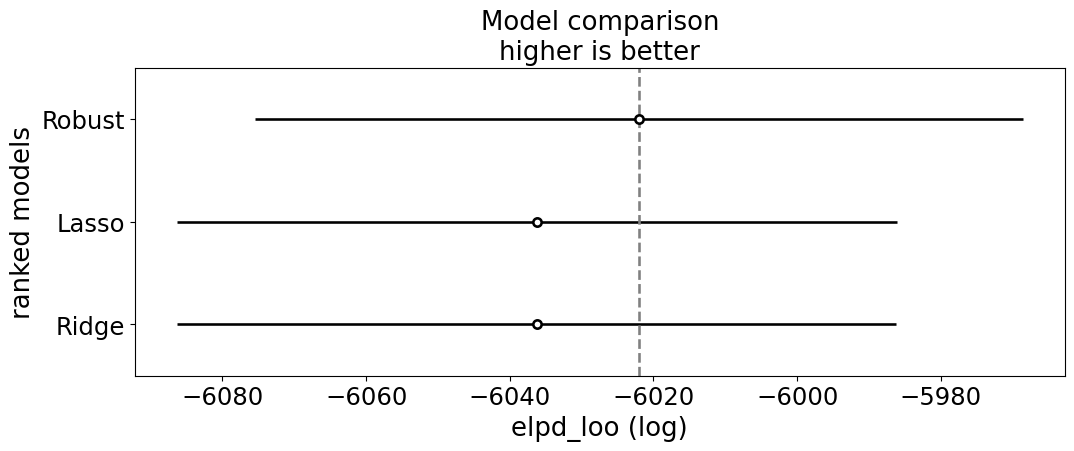

In [59]:
model_compare = az.compare(
    {
        "Ridge": trace_norm,
        "Lasso": trace_lasso,
        "Robust": trace_robust
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [60]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Robust,0,-6022.064814,3.597540,0.000000,0.95533,53.436838,0.000000,False,log
Lasso,1,-6036.226028,2.790925,14.161213,0.02238,50.094253,7.669560,False,log
Ridge,2,-6036.283117,2.835715,14.218303,0.02229,50.041909,7.695556,False,log


Após a análise dos modelos, os resultados indicam que o modelo robusto apresentou o melhor desempenho em ambas as comparações – tanto na relação entre rendimento de culturas (crop yield) e pesticidas quanto na relação entre rendimento de culturas e precipitação (rainfall). Em seguida, o modelo Lasso se posicionou como o segundo mais eficaz, enquanto o modelo Ridge ficou em último lugar.